# Signal processing and analysis of human brain potentials (EEG) [Exercise 9]


(5000,)

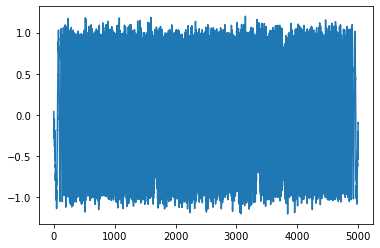

In [1]:
import ccs_eeg_utils
import numpy as np
import scipy
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2
sig = ccs_eeg_utils.simulate_TF(signal=3)

plt.plot(sig)
sig.shape

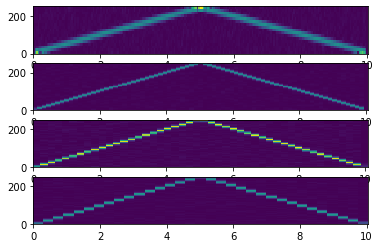

In [2]:
import mne
nseglist = np.arange(32,256,64)

for (k,n) in enumerate(nseglist):
    
    (f,t,x) = scipy.signal.stft(sig,fs=500,nperseg=n,noverlap=n*0.3)

    plt.subplot(len(nseglist),1,k+1).imshow(np.abs(x),origin='lower',interpolation='none',aspect='auto',extent=[min(t),max(t),min(f),max(f)])
    


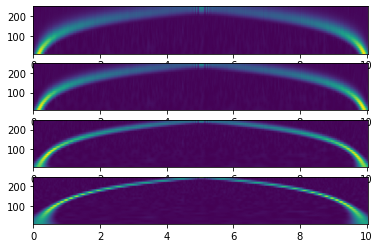

In [3]:
import mne
#freqs = np.arange(10,250,1)
freqs = np.logspace(*np.log10([10, 250]), num=25)

cyclist= [3,4,8,16]
for (k,cyc) in enumerate(cyclist):
    power = mne.time_frequency.tfr_array_morlet(sig.reshape(1,1,-1), sfreq=500,freqs=freqs, n_cycles=cyc)
    plt.subplot(len(cyclist),1,k+1).imshow(np.abs(power[0,0,:,:]),aspect="auto",origin='lower', extent=[min(t),max(t),min(freqs),max(freqs)])


### TF of EEG Dataset
Get a partially preprocessed P3 Dataset from the ERP-Core:
```
epochs = ccs_eeg_utils.get_TF_dataset(  subject_id = '002',bids_root = "../local/bids")
```
We are looking only at epochs relative to the responses. 


In [ ]:
epochs = ccs_eeg_utils.get_TF_dataset(  subject_id = '002',bids_root = "../local/bids")


We want to get an overview of the power. So for starters we choose bad frequency resolution but good time resolution with a wavelet transform.

We will evaluate the TF at `freqs = np.logspace(*np.log10([5, 80]), num=25)` with 1 cycle. 
 
Run:
``` 
power_total = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=4,average=True) # ITC, inter-trial-coherence is quite similar to evoked power, it is a measure of phase consistency over trials but we havent discussed it in the lecture.
``` 

In [5]:
freqs = np.logspace(*np.log10([5, 80]), num=25)
n_cycles = 1 
power_total = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=4,average=True)

Loading data for 202 events and 3073 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    7.2s finished


Next we will visualize all TFs at all electrodes and get an overview whats going on. If you use `%matplotlib qt` the plot will be interactive.
Choose a baseline of -.5 to 0 using the command `power.plot_topo()` 

Applying baseline correction (mode: logratio)


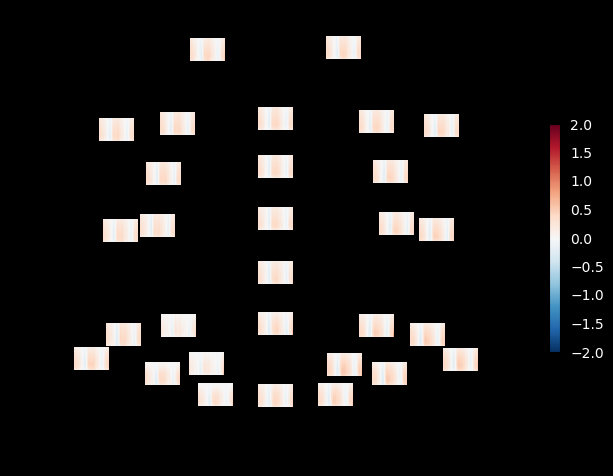

In [10]:
%matplotlib qt
power_total.plot_topo(baseline=[-.5,0],mode="logratio",vmin=-2,vmax=2);

**T:** Plot the power at electrode Cz using power.plot():

    1. Without any baseline
    2. With a baseline of your choice

**T:** Explain the general pattern you see. Can you spot differences betweem with and without baseline?

No baseline correction applied
Applying baseline correction (mode: percent)


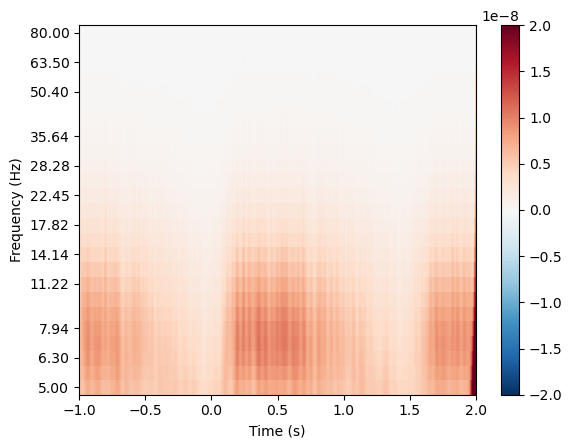

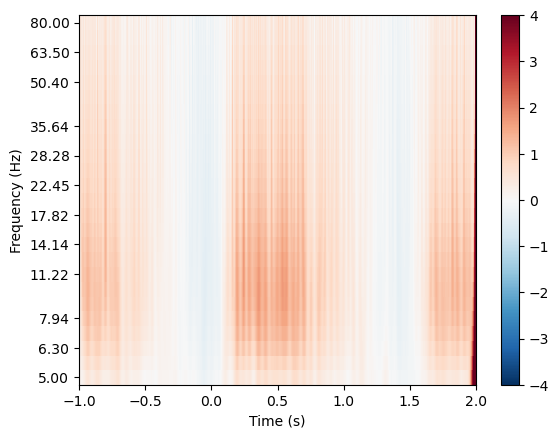

In [11]:
power_total.plot(baseline=None,vmin=-2*10e-9,vmax=2*10e-9,picks='Cz');
power_total.plot(baseline=[-.5,0],mode='percent',vmin=-4,vmax=4,picks='Cz');


**T:** Now lets improve upon our frequency resolution `nz`, increasing the number of cycles to 3. Plot channel Cz with BSL correction (-0.5,1).

Tipp: you can speed up the calculation by specifying `picks="Cz"`

In [24]:

n_cycles = 5
power_total = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=4,average=True,picks='Cz')



Loading data for 202 events and 3073 original time points ...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.9s finished


Applying baseline correction (mode: percent)


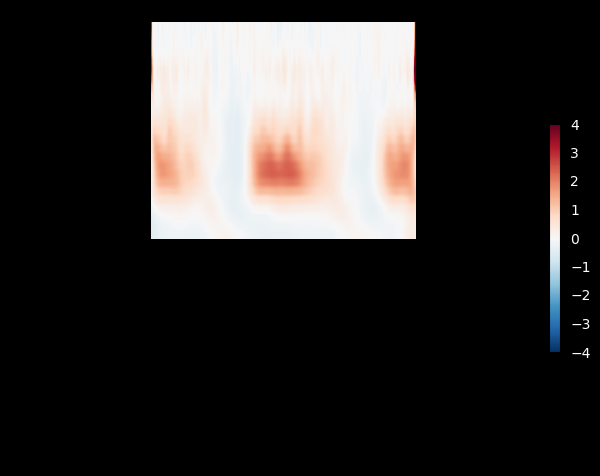

In [25]:
power_total.plot_topo(baseline=[-.5,0],mode='percent',vmin=-4,vmax=4);

**T:** We also want to calculate the induced and evoked TF. For this we first calculate the induced spectrum, then subtract the total from the induced.

1. `epochs.subtract_evoked()` is a function that removes the ERP from each trial. It is a mne-consistent function that practically does:
`epochs_induced._data = epochs._data  - epochs.average().data`. Run the tfr analysis again on the induced dataset, remember that if you dont make a copy of your epochs (via `epochs.copy()`) the dataset will be overwritten in memory

2. In order to get epochs_evoked, we have to subtract total and induced. We cand do this via 
```python
power_evoked = mne.combine_evoked([power_total,power_induced],weights=[1,-1])
```
Note: you could use this function also to combine/subtract condition effects!

**T:** Visualize evoked, total & induced for electrode Cz

In [19]:

epochs_induced = epochs.copy()
#epochs_induced._data = epochs_induced._data  - epochs_induced.average().data # but we are using the offocial way here
epochs_induced.subtract_evoked()

power_induced = mne.time_frequency.tfr_morlet(epochs_induced, freqs=freqs, n_cycles=n_cycles, return_itc=False,n_jobs=1,average=True,picks="Cz")

Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: HEOG_left, VEOG_lower, HEOG_right
[done]
Loading data for 202 events and 3073 original time points ...


In [20]:
power_induced

<AverageTFR | time : [-1.000000, 2.000000], freq : [5.000000, 80.000000], nave : 202, channels : 1, ~620 kB>

Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


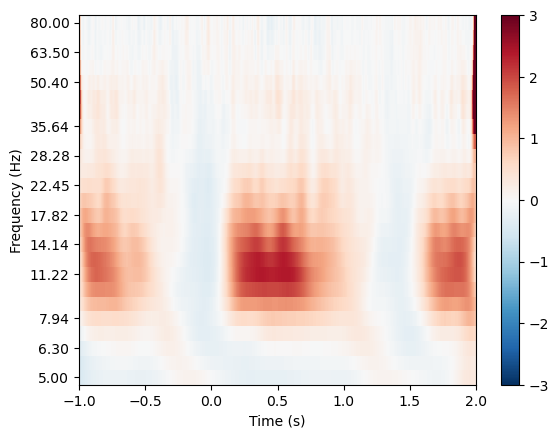

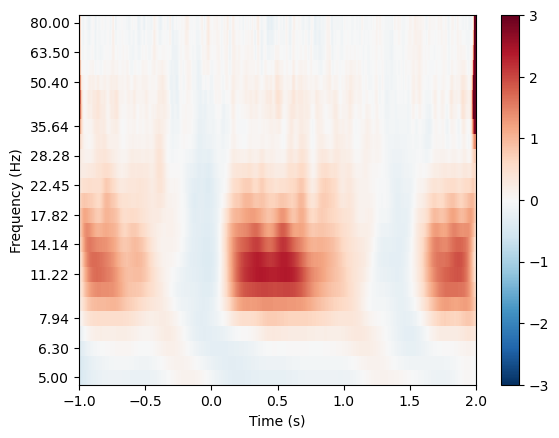

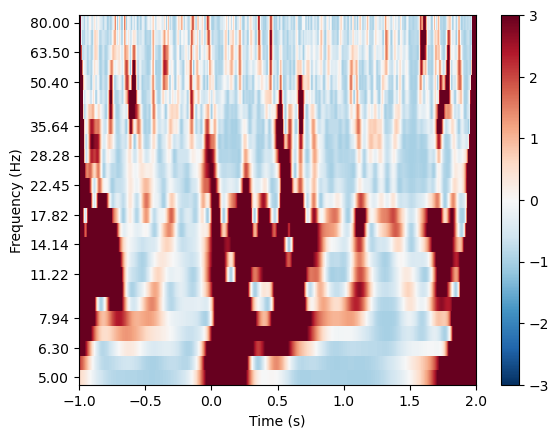

In [21]:
%matplotlib qt
power_evoked = mne.combine_evoked([power_total,power_induced],weights=[1,-1])

mode = "percent"
bsl = [-0.5,0]
cmin = -3
cmax = -cmin
power_total.plot(baseline=bsl,mode=mode,picks='Cz',vmin=cmin,vmax=cmax)
power_induced.plot(baseline=bsl,mode=mode,picks='Cz',vmin=cmin,vmax=cmax)
power_evoked.plot(baseline=bsl,mode=mode,picks='Cz',vmin=cmin,vmax=cmax);



Applying baseline correction (mode: percent)


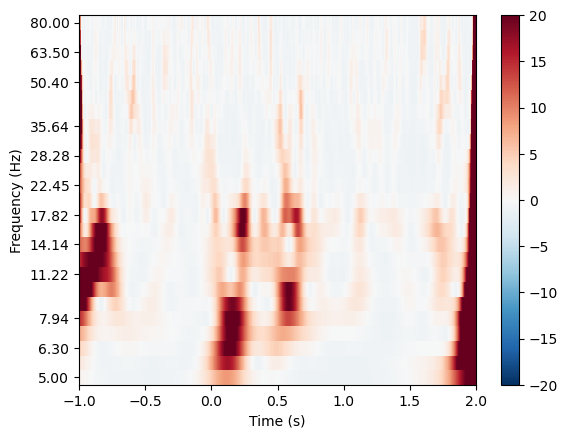

In [22]:
power_evoked.plot(baseline=bsl,mode=mode,picks='Cz',vmin=-20,vmax=20);

Applying baseline correction (mode: percent)


[<Figure size 640x480 with 2 Axes>]

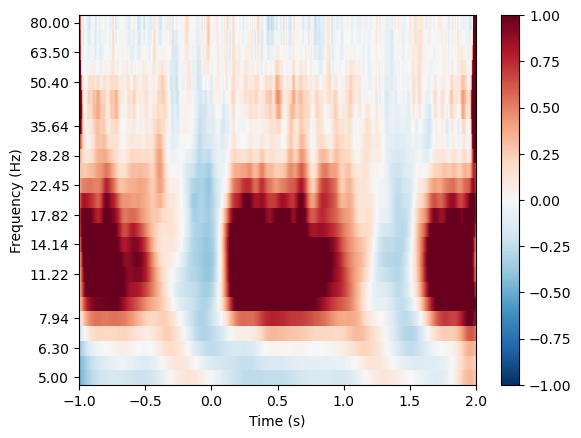

In [23]:
power_total.plot(baseline=bsl,mode=mode,picks='Cz',vmin=-1,vmax=1)